In [39]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Wine example

In [138]:
from lux.lux import LUX
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
wine = datasets.load_wine()

In [139]:
from sklearn.ensemble import RandomForestClassifier

features = [f.replace('/','_') for  f in wine['feature_names']]
target = 'class'
rs=42
fraction=0.1

#create daatframe with columns names as strings (LUX accepts only DataFrames with string columns names)
df_wine = pd.DataFrame(wine.data,columns=features)
df_wine[target] = wine.target

#train classifier
train, test = train_test_split(df_wine, random_state=rs)
clf = RandomForestClassifier(random_state=42)#svm.SVC(probability=True, random_state=rs)
clf.fit(train[features],train[target])
clf.score(test[features],test[target])

1.0

## Without predictor uncertainty

In [140]:
#pick some instance from datasetr
i2e = train[features].sample(1, random_state=42).values
i2e

#train lux on neighbourhood equal 30% instances
lux = LUX(predict_proba = lambda x: np.round(clf.predict_proba(x)), neighborhood_size=int(len(train)*fraction),max_depth=2,  node_size_limit = 1, grow_confidence_threshold = 0 )
lux.fit(train[features], train[target], instance_to_explain=i2e,class_names=[0,1,2])

#see the justification of the instance being classified for a given class
lux.justify(np.array(i2e))

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
The default value of `dual` will change from `True` to `'auto'` in 1.5. 

['IF malic_acid >=1.7067009210586548 AND od280_od315_of_diluted_wines < -0.5412150734518947 * flavanoids+2.6793544419044264 THEN class = 2 # 1.0\n']

In [141]:
#calculate decision tree score over this dataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from lux.pyuid3.data import Data
data = Data.parse_dataframe(test[features+[target]])
    
predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
print(f'Accuracy : {accuracy_score(predictions, test[target])}')


Accuracy : 0.8666666666666667


In [142]:
# #prind the uncertain local tree for the given instance
# import graphviz
# lux.uid3.tree.save_dot('tree.dot')
# graphviz.Source.from_file('tree.dot')b

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

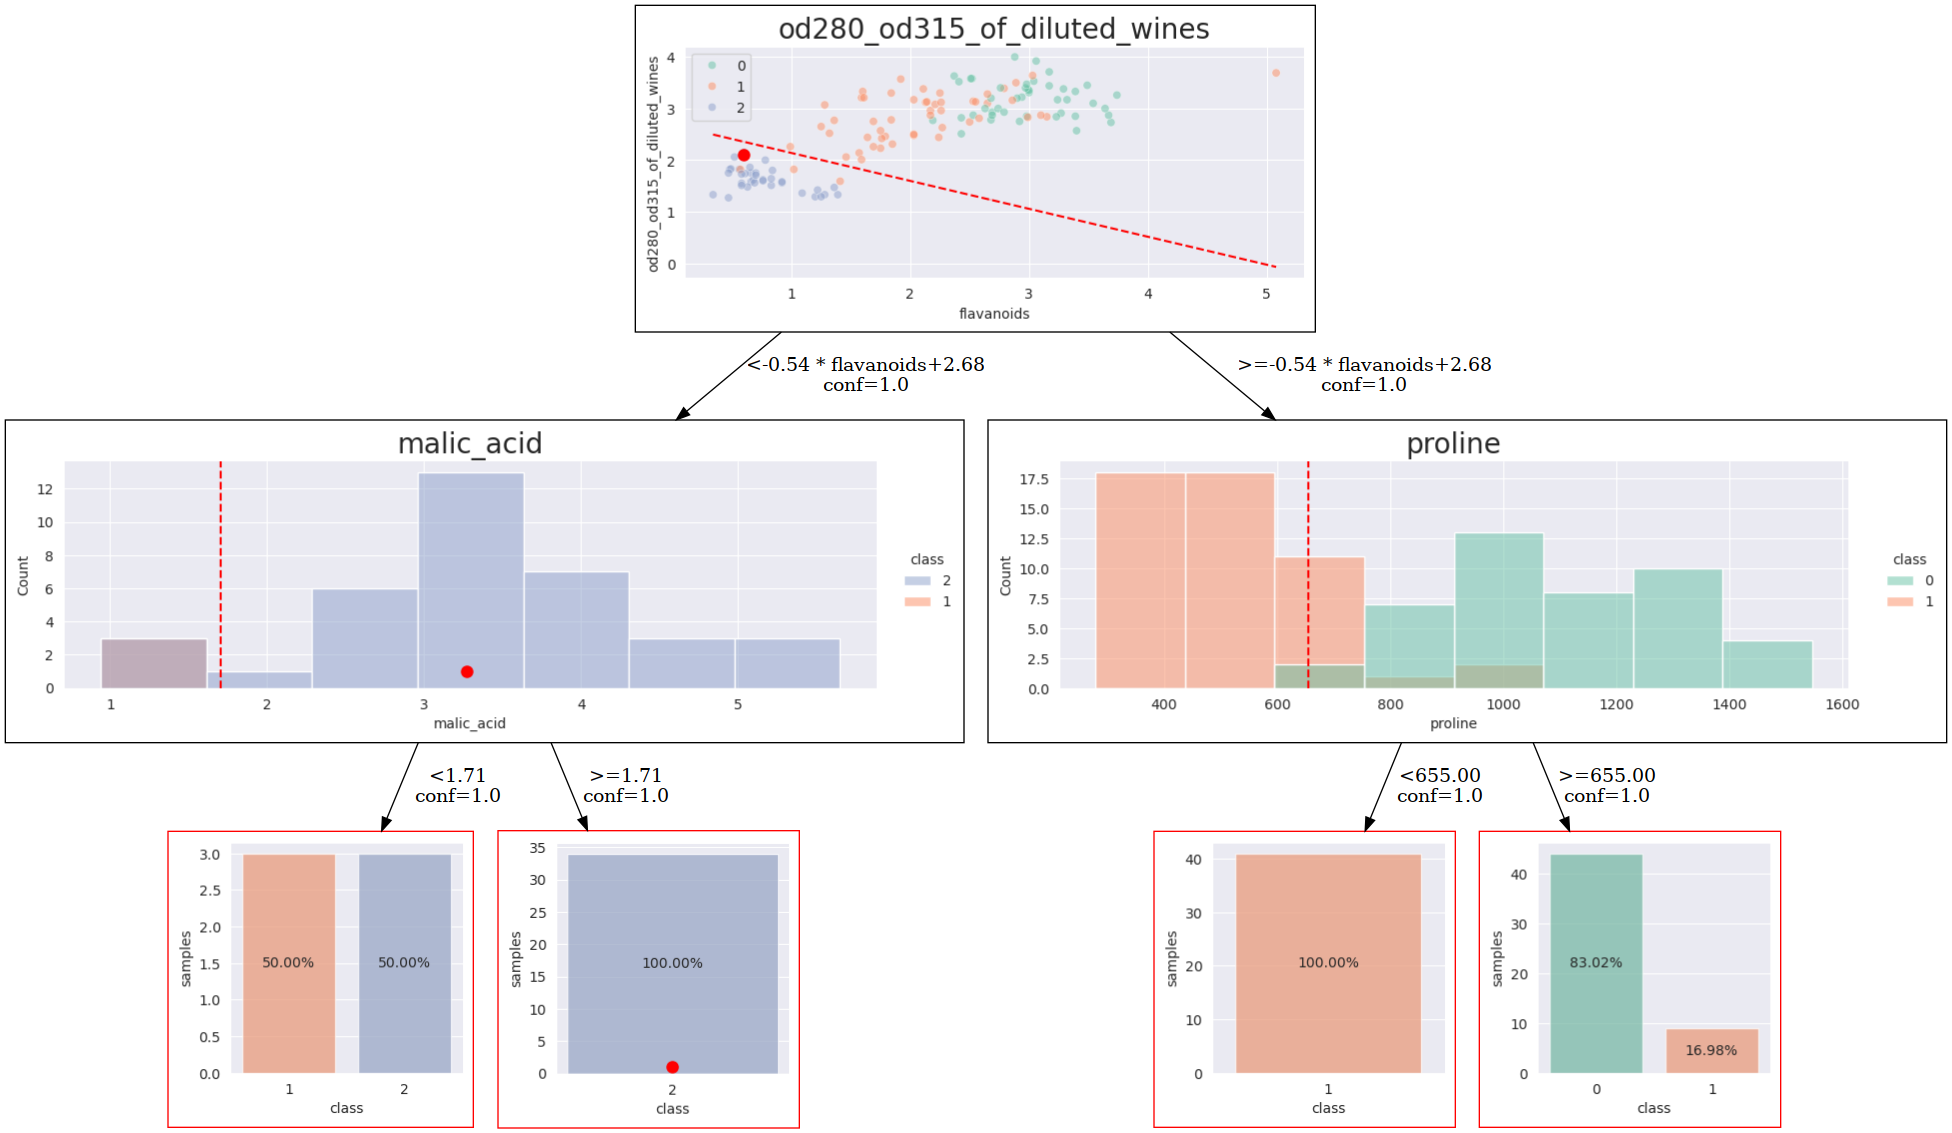

In [143]:
import graphviz
from graphviz import Source
from IPython.display import SVG, Image
i2edf = pd.DataFrame(i2e, columns=features)
i2edf[target] =clf.predict(i2edf.values.reshape(1,-1))[0]
lux.uid3.tree.save_dot('tree-wine.dot',fmt='.2f',visual=True, background_data=train,  instance2explain=i2edf)
gvz=graphviz.Source.from_file('tree-wine.dot')
!dot -Tpng tree-wine.dot > tree-wine.png
Image('tree-wine.png')

## Without SHAP

In [144]:
#pick some instance from datasetr
i2e = train[features].sample(1, random_state=42).values

#train lux on neighbourhood equal 20 instances
lux = LUX(predict_proba = clf.predict_proba, neighborhood_size=int(len(train)*fraction),max_depth=2,  node_size_limit = 1, grow_confidence_threshold = 0 )
lux.fit(train[features], train[target], instance_to_explain=i2e,oversampling=False, class_names=[0,1,2])

#see the justification of the instance being classified for a given class
lux.justify(np.array(i2e))

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names
The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.


['IF od280_od315_of_diluted_wines <2.2050000429153442 THEN class = 2 # 0.9285714285714286\n']

In [145]:
#calculate decision tree score over this dataset

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from lux.pyuid3.data import Data
data = Data.parse_dataframe(test[features+[target]])
    
predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
print(f'Accuracy : {accuracy_score(predictions, test[target])}')


Accuracy : 0.8222222222222222


In [146]:
# #prind the uncertain local tree for the given instance
# import graphviz
# lux.uid3.tree.save_dot('tree.dot')
# graphviz.Source.from_file('tree.dot')

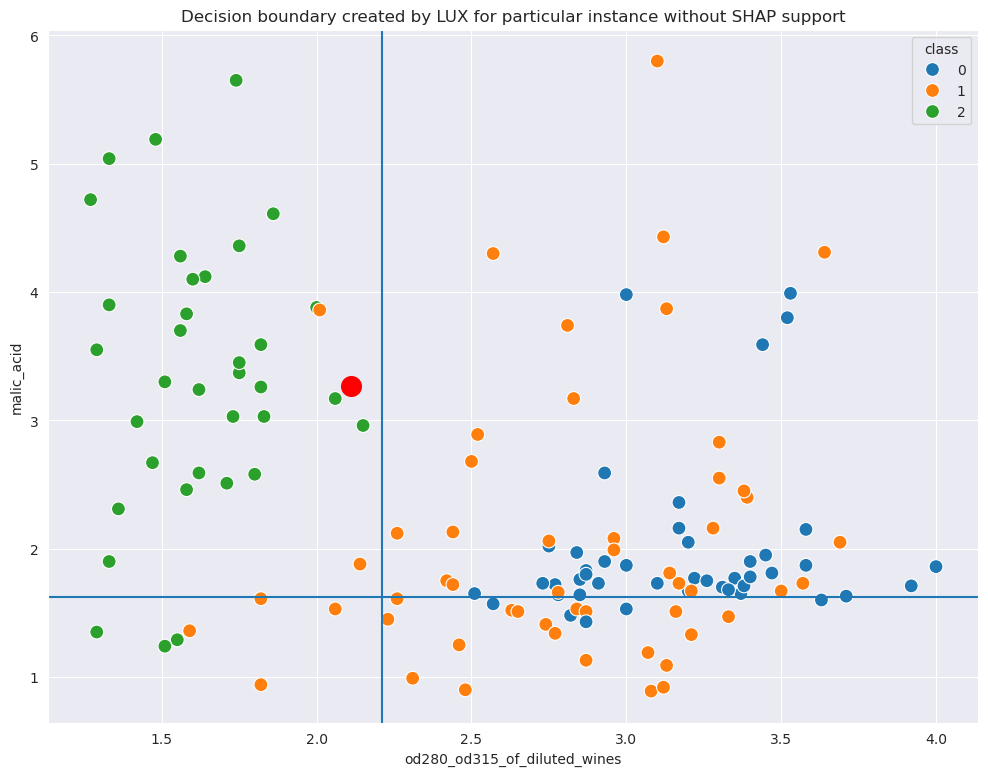

In [147]:
plt.figure(figsize=(12,9))
graph=sns.scatterplot(x='od280_od315_of_diluted_wines',y='malic_acid', data=train[['od280_od315_of_diluted_wines','malic_acid',target]],hue=target,s=100)
plt.scatter(data=pd.DataFrame(i2e,columns=features),x='od280_od315_of_diluted_wines',y='malic_acid', marker='o',color='r', s=200)
graph.axvline(2.21)
graph.axhline(1.62)
plt.title('Decision boundary created by LUX for particular instance without SHAP support')
plt.savefig('noshap-wine-scatter.png', format='png',bbox_inches='tight')
plt.show()

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

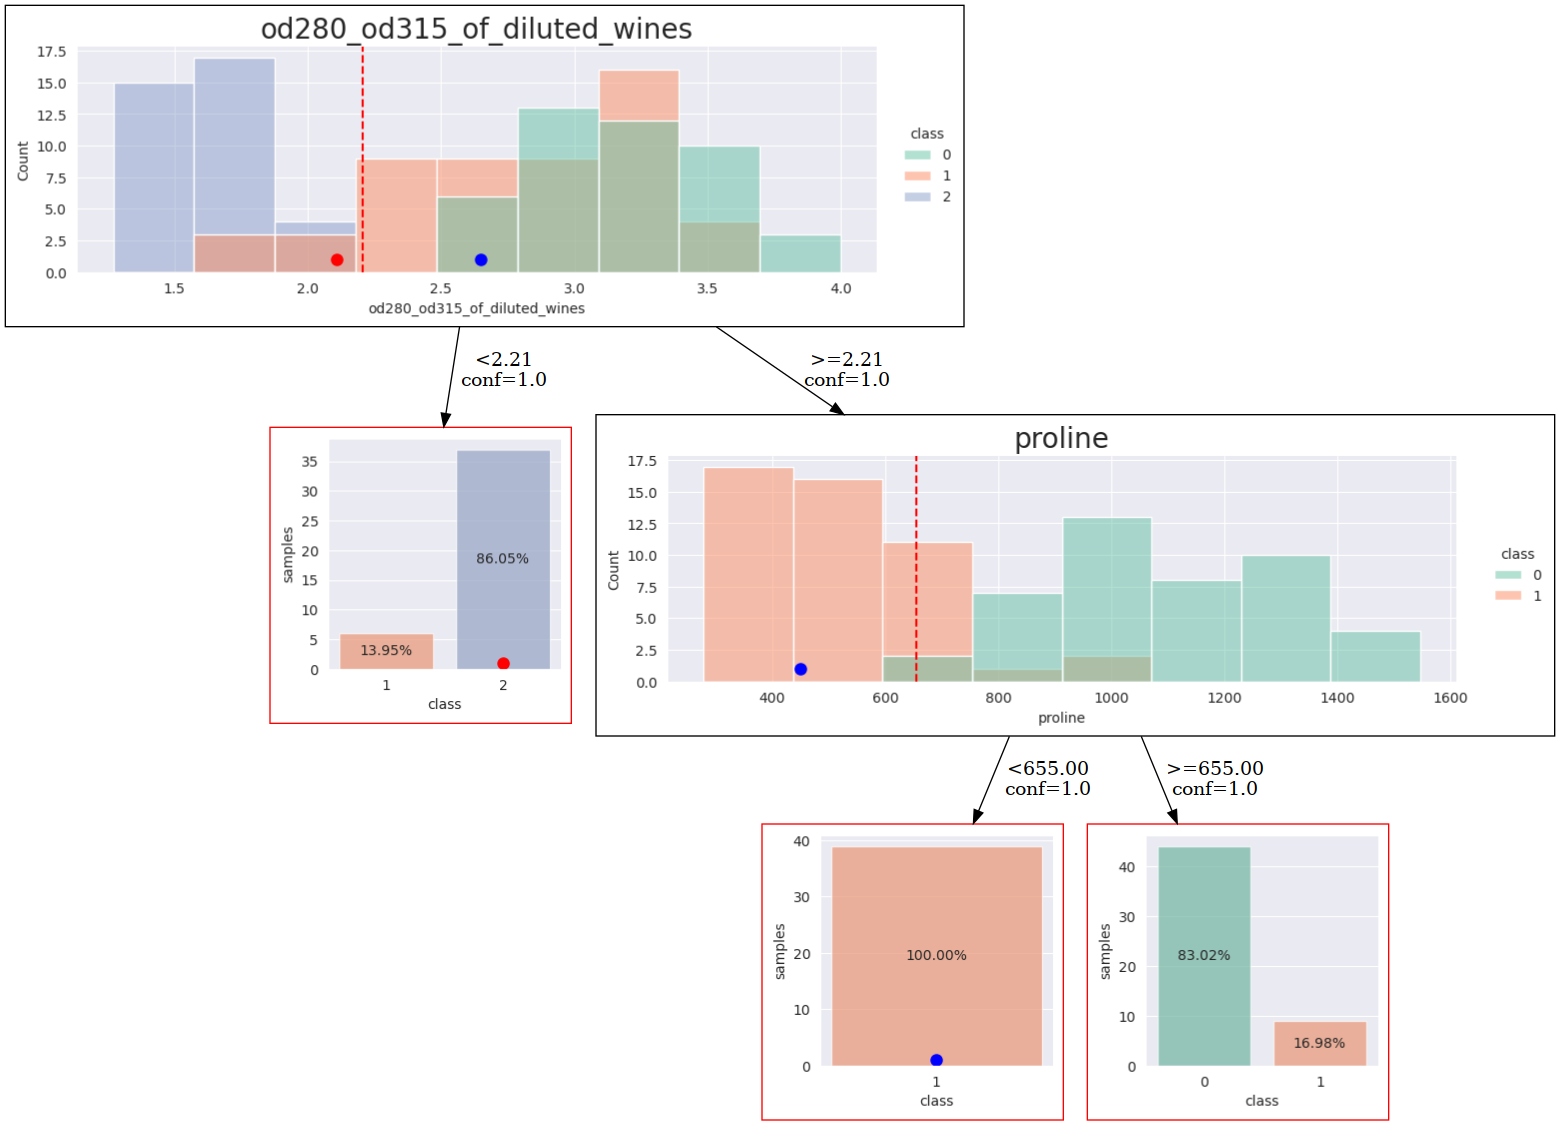

In [148]:
cf = lux.counterfactual(np.array(i2e), train[features], counterfactual_representative='medoid', topn=1)[0]
lux.visualize(data=train,target_column_name='class',instance2explain=i2e,counterfactual=cf,filename='tree-wine.dot' )
gvz=graphviz.Source.from_file('tree-wine.dot')
!dot -Tpng tree-wine.dot > tree-wine.png
Image('tree-wine.png')

## With SHAP

In [149]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(clf, train[features])
shap_values = explainer.shap_values(train[features],check_additivity=False)

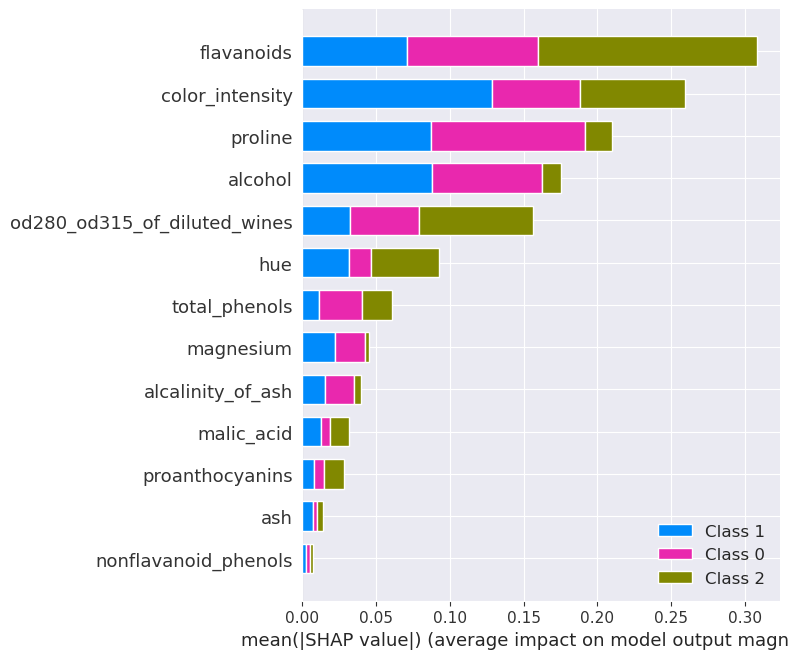

In [150]:
plt.figure()
shap.summary_plot(shap_values, features=None, feature_names=features, max_display=None, show=False)
plt.savefig('shap-wine.png', format='png',bbox_inches='tight')
plt.show()

In [151]:
#train lux on neighbourhood equal 20% instances
lux = LUX(predict_proba = clf.predict_proba, classifier=clf, neighborhood_size=int(len(train)*fraction),max_depth=2,  node_size_limit = 3, grow_confidence_threshold = 0 )
lux.fit(train[features], train[target], X_importances = None,  instance_to_explain=i2e,class_names=[0,1,2],discount_importance=False)

#see the justification of the instance being classified for a given class
lux.justify(np.array(i2e))

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitt

['IF flavanoids <0.9892404973506927 AND color_intensity >=2.2684783935546875 THEN class = 2 # 1.0\n']

In [152]:
#calculate decision tree score over this dataset

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from lux.pyuid3.data import Data
data = Data.parse_dataframe(test[features+[target]])
    
predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
print(f'Accuracy : {accuracy_score(predictions, test[target])}')


Accuracy : 0.8888888888888888


In [153]:
#prind the uncertain local tree for the given instance
# import graphviz
# lux.uid3.tree.save_dot('tree.dot')
# graphviz.Source.from_file('tree.dot')

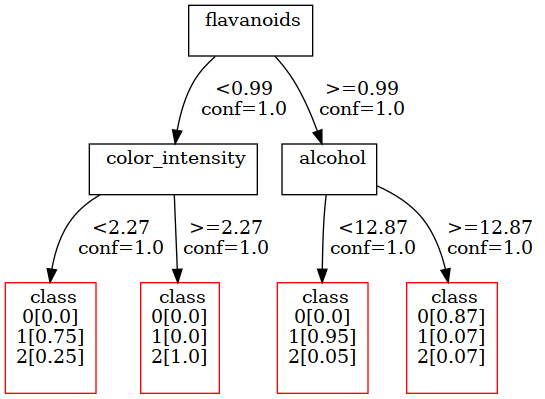

In [154]:
lux.uid3.tree.save_dot('tree-gv.dot',fmt='.2f')
gvz=graphviz.Source.from_file('tree-gv.dot')
!dot -Tpng tree-gv.dot > tree-gv.png
Image('tree-gv.png')

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

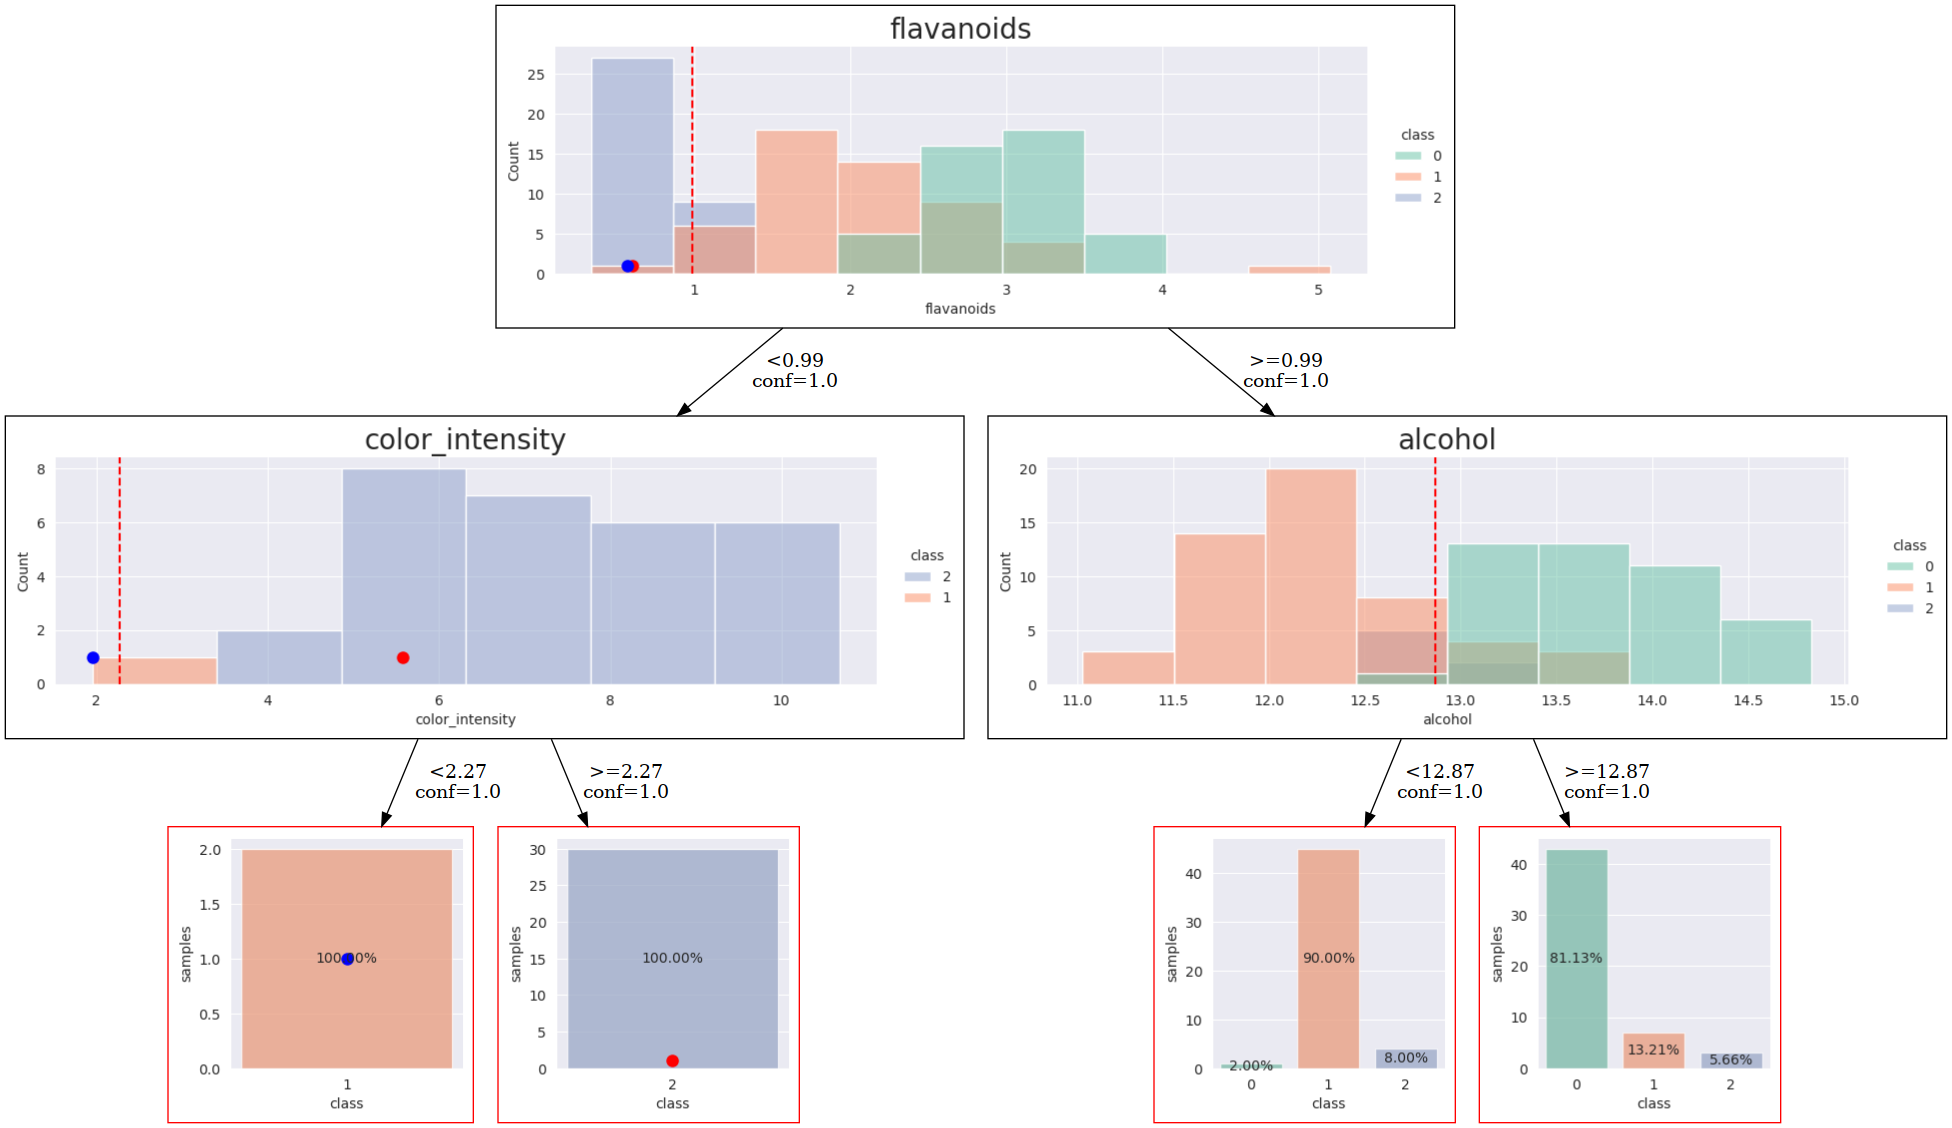

In [155]:
import graphviz
from IPython.display import SVG, Image
cf = lux.counterfactual(np.array(i2e), train[features], counterfactual_representative='medoid', topn=1)[0]
cfdf = pd.DataFrame(cf['counterfactual']).T
cfdf[target] = clf.predict(cfdf.values.reshape(1,-1))[0]
i2edf = pd.DataFrame(i2e, columns=features)
i2edf[target] =clf.predict(i2edf.values.reshape(1,-1))[0]
lux.uid3.tree.save_dot('tree-wine-shap.dot',fmt='.2f',visual=True, background_data=train,  instance2explain=i2edf,counterfactual=cfdf)
gvz=graphviz.Source.from_file('tree-wine-shap.dot')
!dot -Tpng tree-wine-shap.dot > tree-wine-shap.png
Image('tree-wine-shap.png')

In [156]:
cf

{'rule': {'flavanoids': ['<0.9892404973506927'],
  'color_intensity': ['<2.2684783935546875']},
 'prediction': '1',
 'confidence': 0.75,
 'covered':     alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
 59    12.37        0.94  1.36               10.6       88.0           1.98   
 
     flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
 59        0.57                  0.28             0.42             1.95  1.05   
 
     od280_od315_of_diluted_wines  proline  
 59                          1.82    520.0  ,
 'counterfactual': alcohol                          12.37
 malic_acid                        0.94
 ash                               1.36
 alcalinity_of_ash                10.60
 magnesium                        88.00
 total_phenols                     1.98
 flavanoids                        0.57
 nonflavanoid_phenols              0.28
 proanthocyanins                   0.42
 color_intensity                   1.95
 hue               

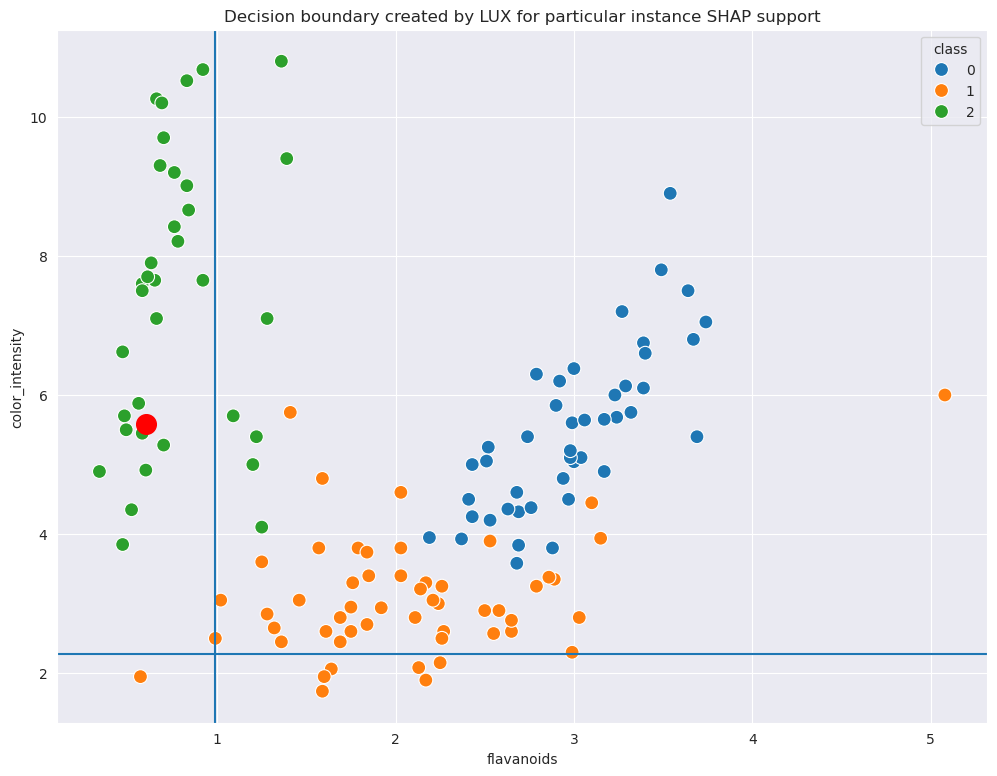

In [158]:
plt.figure(figsize=(12,9))
graph=sns.scatterplot(x='flavanoids',y='color_intensity', data=train[['flavanoids','color_intensity',target]],hue=target,s=100)
graph.axvline(0.99)
graph.axhline(2.27)
plt.scatter(data=pd.DataFrame(i2e,columns=features),x='flavanoids',y='color_intensity', marker='o', color='r',s=200)
plt.title('Decision boundary created by LUX for particular instance SHAP support')
plt.savefig('shap-wine-scatter.png', format='png',bbox_inches='tight')
plt.show()

# Breast cancer

In [59]:
from lux.lux import LUX
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
import numpy as np
import pandas as pd
# import some data to play with
cancer = datasets.load_breast_cancer()

In [60]:
features = [f.replace(" ","_") for f in cancer['feature_names']]
target = 'calss'
rs=42

#create daatframe with columns names as strings (LUX accepts only DataFrames withj string columns names)
df_cancer = pd.DataFrame(cancer.data,columns=features)
df_cancer[target] = cancer.target

#train classifier
train, test = train_test_split(df_cancer, random_state=rs)
clf = RandomForestClassifier(random_state=42)#svm.SVC(probability=True, random_state=rs)
clf.fit(train[features],train[target])
clf.score(test[features],test[target])

0.965034965034965

## Without predictor uncertinaty

In [61]:
#pick some instance from datasetr
i2e = train[features].sample(1, random_state=42).values

#train lux on neighbourhood equal 30% instances
lux = LUX(predict_proba = lambda x: np.round(clf.predict_proba(x)), neighborhood_size=int(len(train)*fraction),max_depth=2,  node_size_limit = 1, grow_confidence_threshold = 0 )
lux.fit(train[features], train[target], instance_to_explain=i2e,class_names=[0,1])

#see the justification of the instance being classified for a given class
lux.justify(np.array(i2e))

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the valu

['IF worst_concave_points <0.1423499956727028 AND worst_radius <16.755000114440918 THEN class = 1 # 0.9117647058823529\n']

In [62]:
#calculate decision tree score over this dataset

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from lux.pyuid3.data import Data
data = Data.parse_dataframe(test[features+[target]])
    
predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
print(f'Accuracy : {accuracy_score(predictions, test[target])}')


Accuracy : 0.916083916083916


In [63]:
# #prind the uncertain local tree for the given instance
# import graphviz
# lux.uid3.tree.save_dot('tree.dot')
# graphviz.Source.from_file('tree.dot')

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

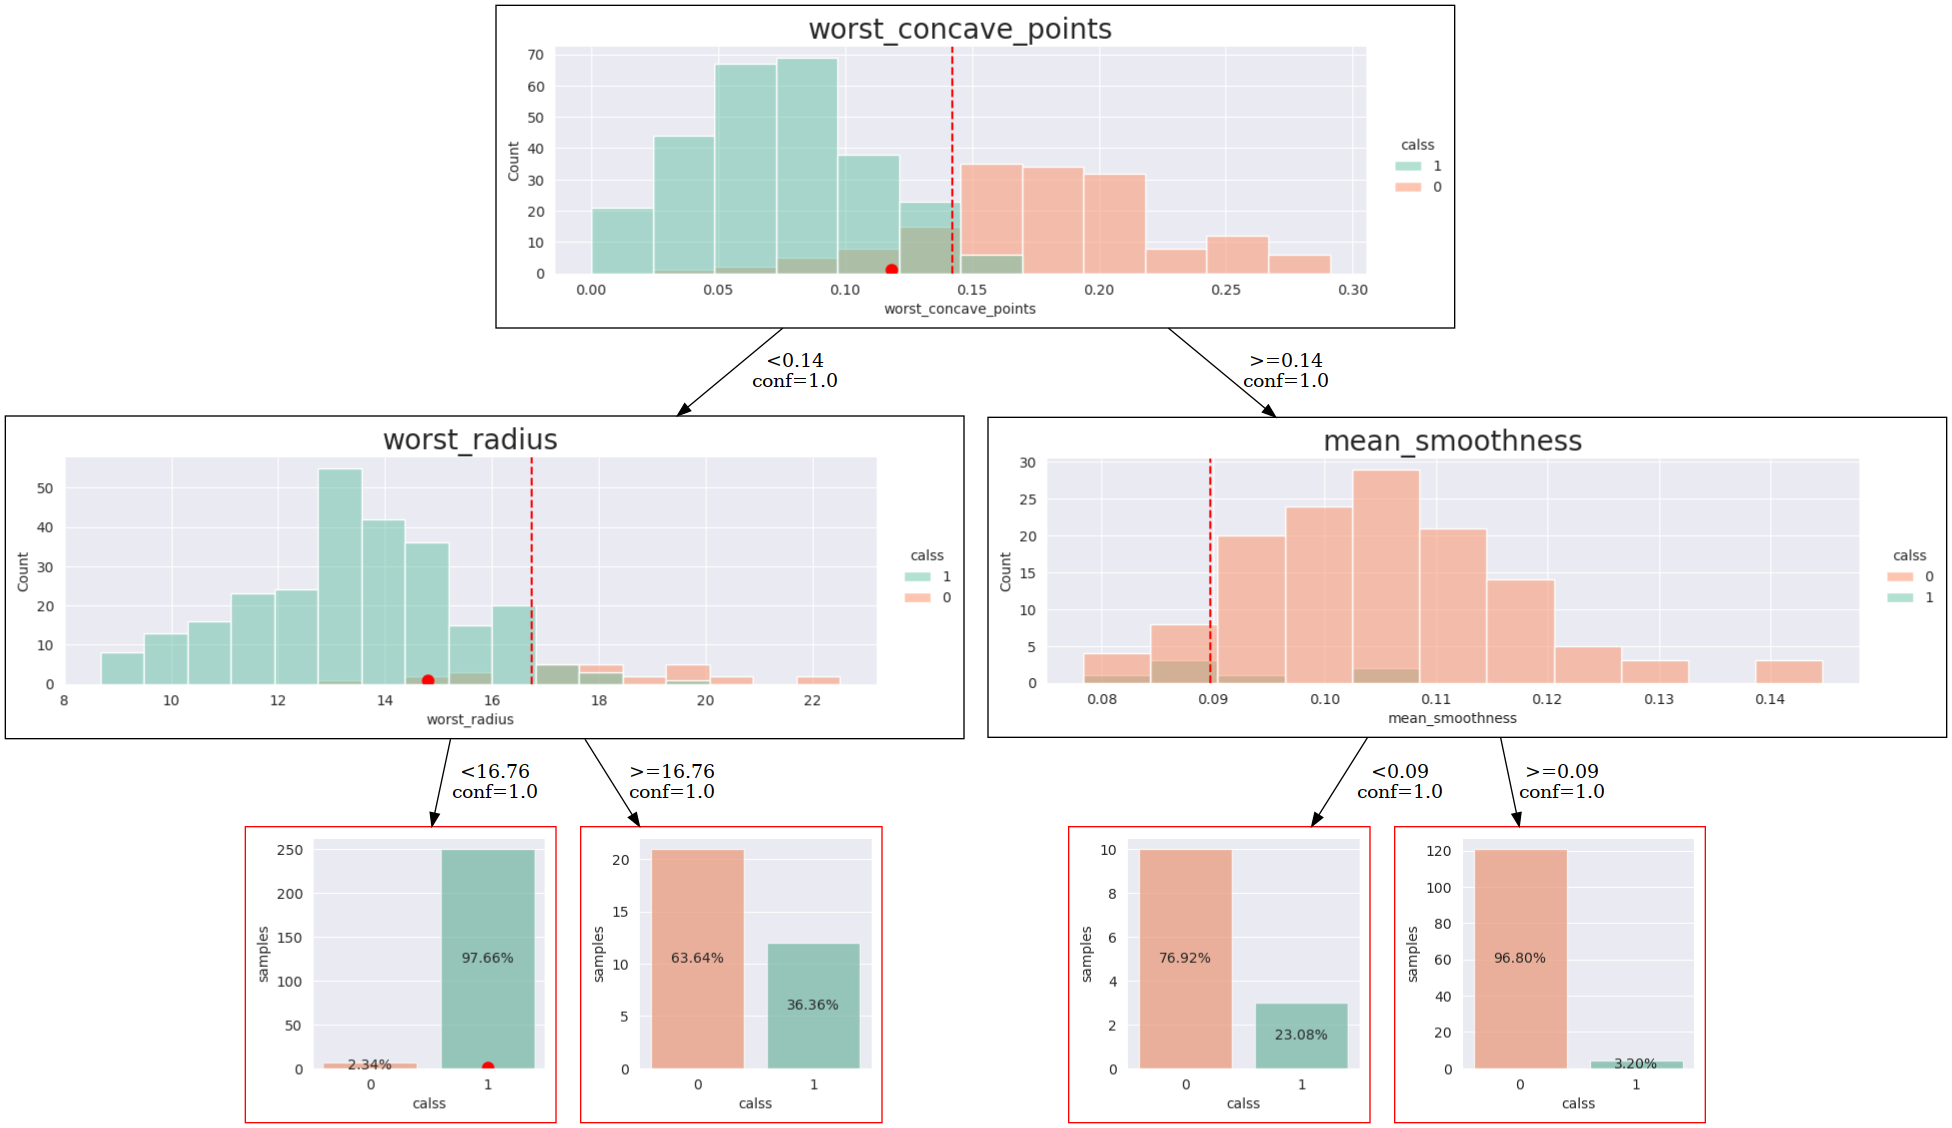

In [64]:
import graphviz
from graphviz import Source
from IPython.display import SVG, Image
i2edf = pd.DataFrame(i2e, columns=features)
i2edf[target] =clf.predict(i2edf.values.reshape(1,-1))[0]
lux.uid3.tree.save_dot('tree-breast.dot',fmt='.2f',visual=True, background_data=train,  instance2explain=i2edf)
gvz=graphviz.Source.from_file('tree-breast.dot')
!dot -Tpng tree-breast.dot > tree-breast.png
Image('tree-breast.png')

## Without SHAP

In [65]:
#pick some instance from datasetr
i2e = train[features].sample(1, random_state=42).values

#train lux on neighbourhood equal 20% instances
lux = LUX(predict_proba = clf.predict_proba, neighborhood_size=int(len(train)*fraction),max_depth=2,  node_size_limit = 1, grow_confidence_threshold = 0 )
lux.fit(train[features], train[target], instance_to_explain=i2e,class_names=[0,1])

#see the justification of the instance being classified for a given class
lux.justify(np.array(i2e))

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the valu

['IF worst_concave_points <0.1423499956727028 AND worst_radius <16.755000114440918 THEN class = 1 # 0.9041095890410957\n']

In [66]:
#calculate decision tree score over this dataset

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from lux.pyuid3.data import Data
data = Data.parse_dataframe(test[features+[target]])
    
predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
print(f'Accuracy : {accuracy_score(predictions, test[target])}')


Accuracy : 0.916083916083916


In [67]:
# #prind the uncertain local tree for the given instance
# import graphviz
# lux.uid3.tree.save_dot('tree.dot')
# graphviz.Source.from_file('tree.dot')

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

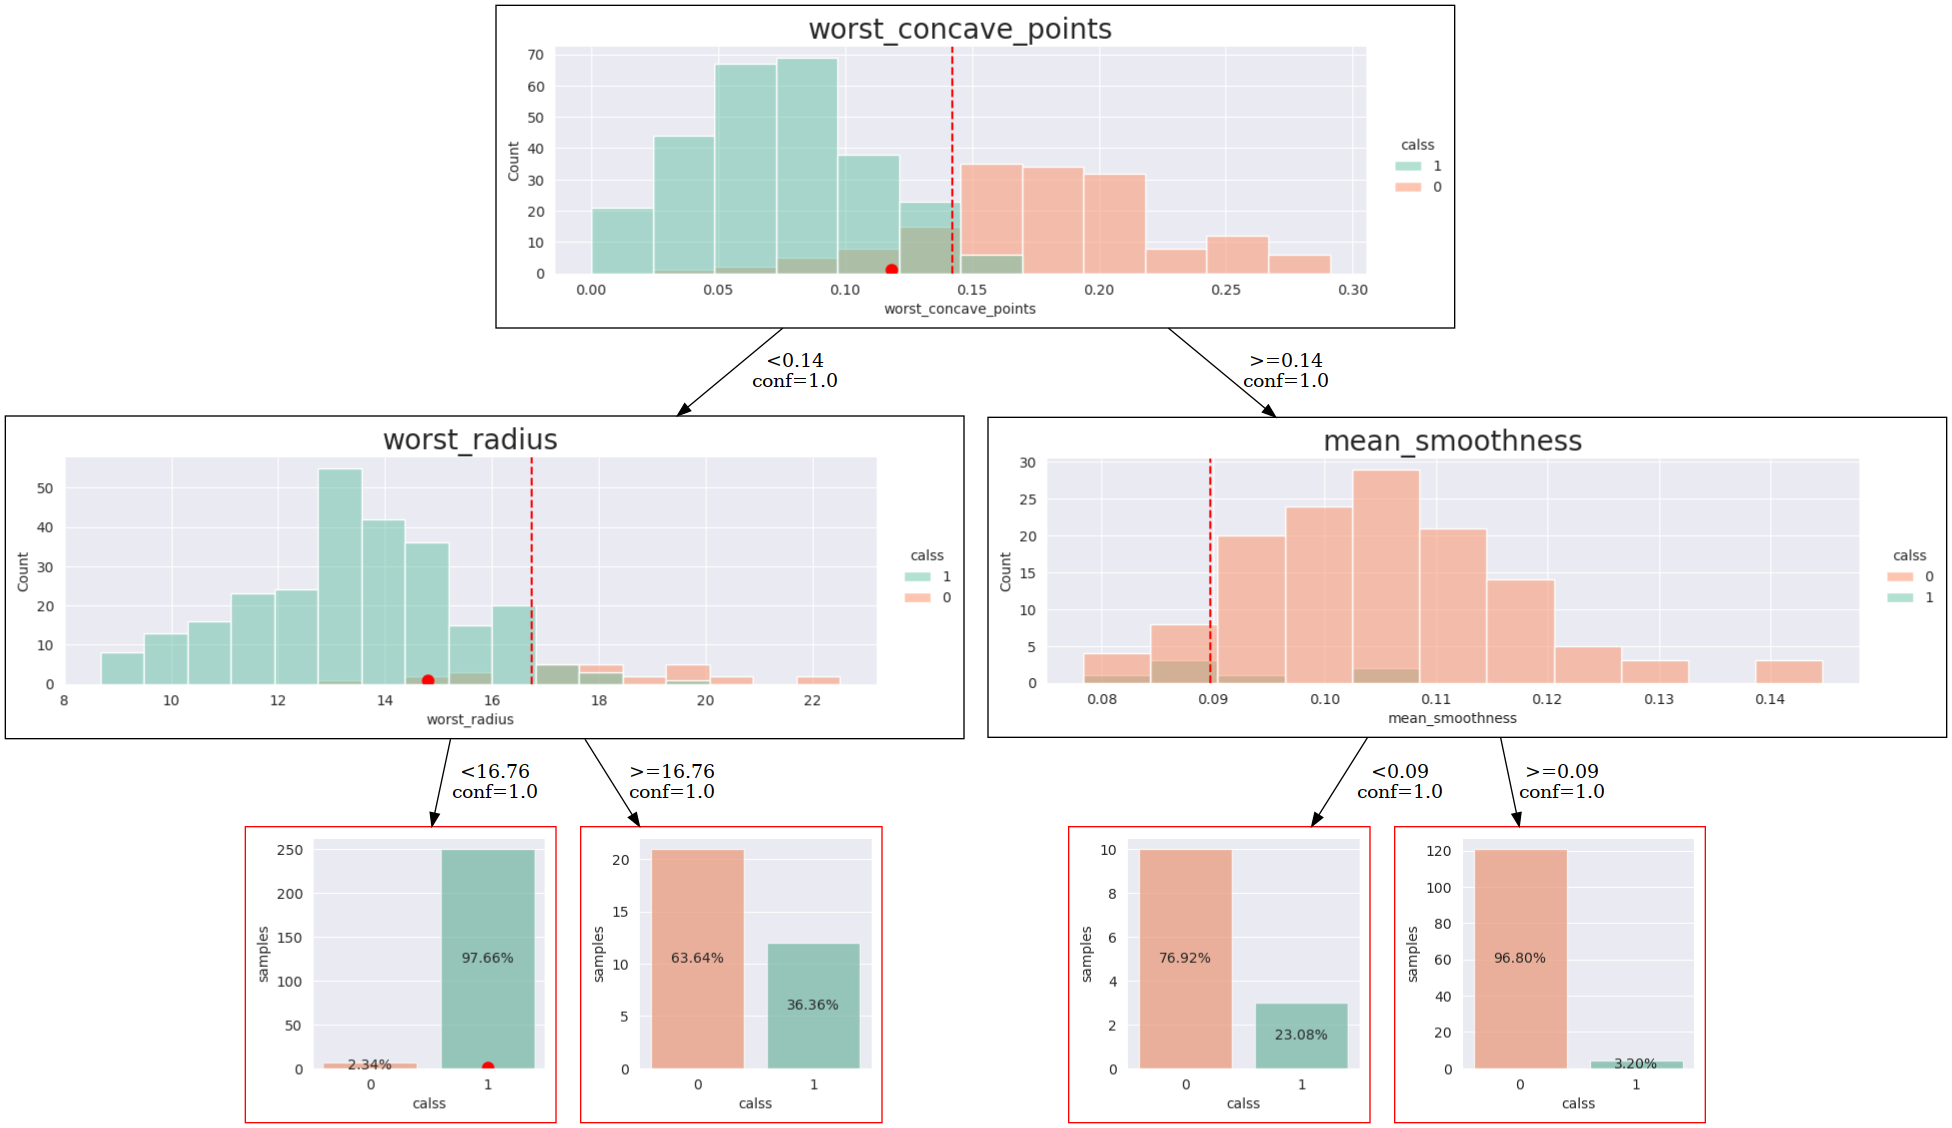

In [68]:
import graphviz
from graphviz import Source
from IPython.display import SVG, Image
i2edf = pd.DataFrame(i2e, columns=features)
i2edf[target] =clf.predict(i2edf.values.reshape(1,-1))[0]
lux.uid3.tree.save_dot('tree-breast.dot',fmt='.2f',visual=True, background_data=train,  instance2explain=i2edf)
gvz=graphviz.Source.from_file('tree-breast.dot')
!dot -Tpng tree-breast.dot > tree-breast.png
Image('tree-breast.png')

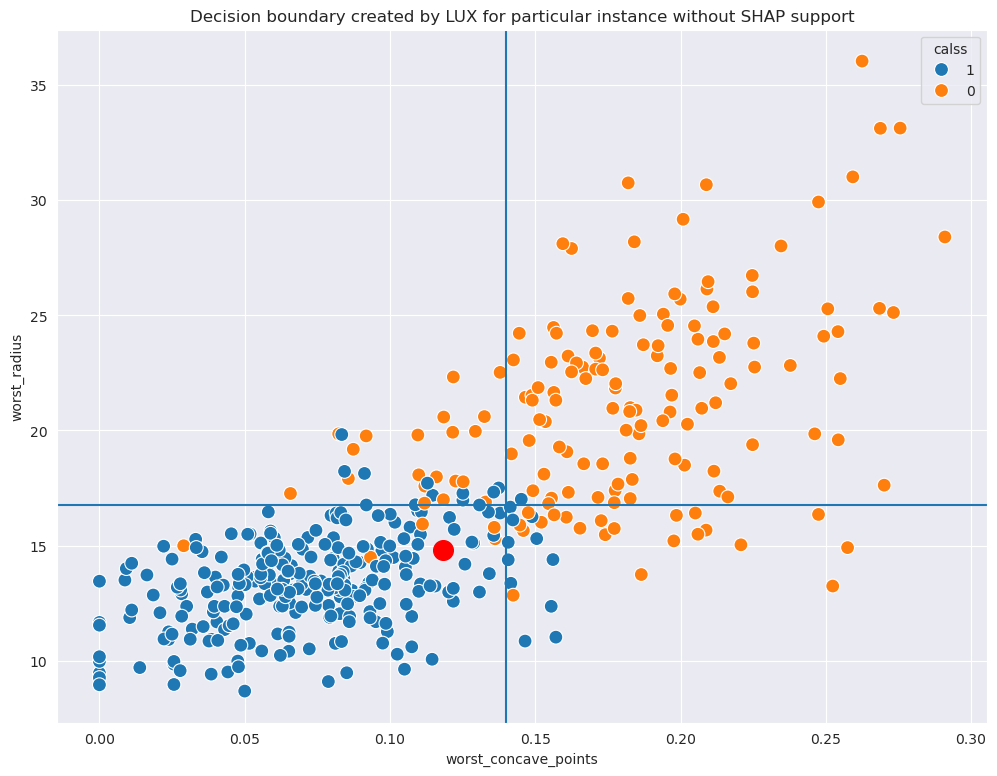

In [69]:
plt.figure(figsize=(12,9))
graph=sns.scatterplot(x='worst_concave_points',y='worst_radius', data=train[['worst_concave_points','worst_radius',target]],hue=target,s=100)
graph.axvline(0.14)
graph.axhline(16.76)
plt.scatter(data=pd.DataFrame(i2e,columns=features),x='worst_concave_points',y='worst_radius', marker='o',color='r', s=200)
plt.title('Decision boundary created by LUX for particular instance without SHAP support')
plt.show()

## With SHAP
You will see that the result is almost the same, but now the explainer uses the same set of features as blackbox model, minimizing the Rashomon effect

In [70]:
import shap
shap.initjs()
# this takes a minute or two since we are explaining over 30 thousand samples in a model with over a thousand trees


explainer = shap.Explainer(clf)
shap_values = explainer.shap_values(train[features],check_additivity=True)

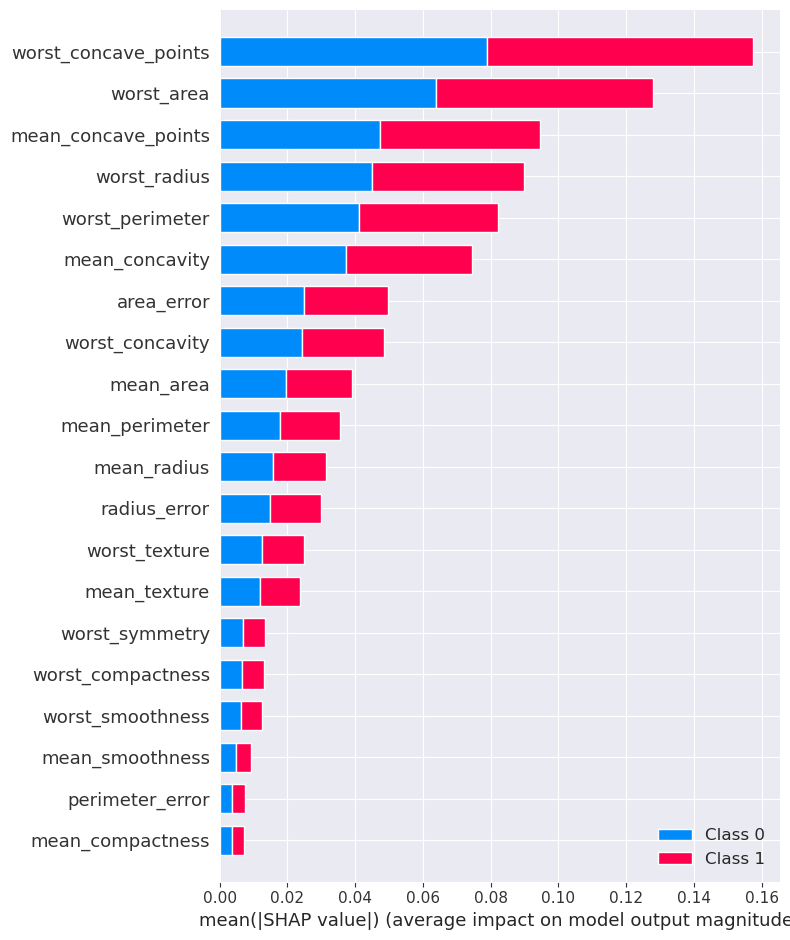

In [71]:
shap.summary_plot(shap_values,train[features])#, features=None, feature_names=features, max_display=None)

In [72]:
#train lux on neighbourhood equal 20% instances
lux = LUX(predict_proba = clf.predict_proba, classifier=clf, neighborhood_size=int(len(train)*fraction),max_depth=2,  node_size_limit = 3, grow_confidence_threshold = 0 )
lux.fit(train[features], train[target], X_importances = None,  instance_to_explain=i2e,class_names=[0,1],discount_importance=False)

#see the justification of the instance being classified for a given class
lux.justify(np.array(i2e))

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier wa

['IF worst_concave_points <0.1423499956727028 THEN class = 1 # 0.9351851851851853\n']

In [73]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from lux.pyuid3.data import Data
data = Data.parse_dataframe(test[features+[target]])
    
predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
print(f'Accuracy : {accuracy_score(predictions, test[target])}')


Accuracy : 0.9230769230769231


In [74]:
# #prind the uncertain local tree for the given instance
# import graphviz
# lux.uid3.tree.save_dot('tree.dot')
# graphviz.Source.from_file('tree.dot')

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

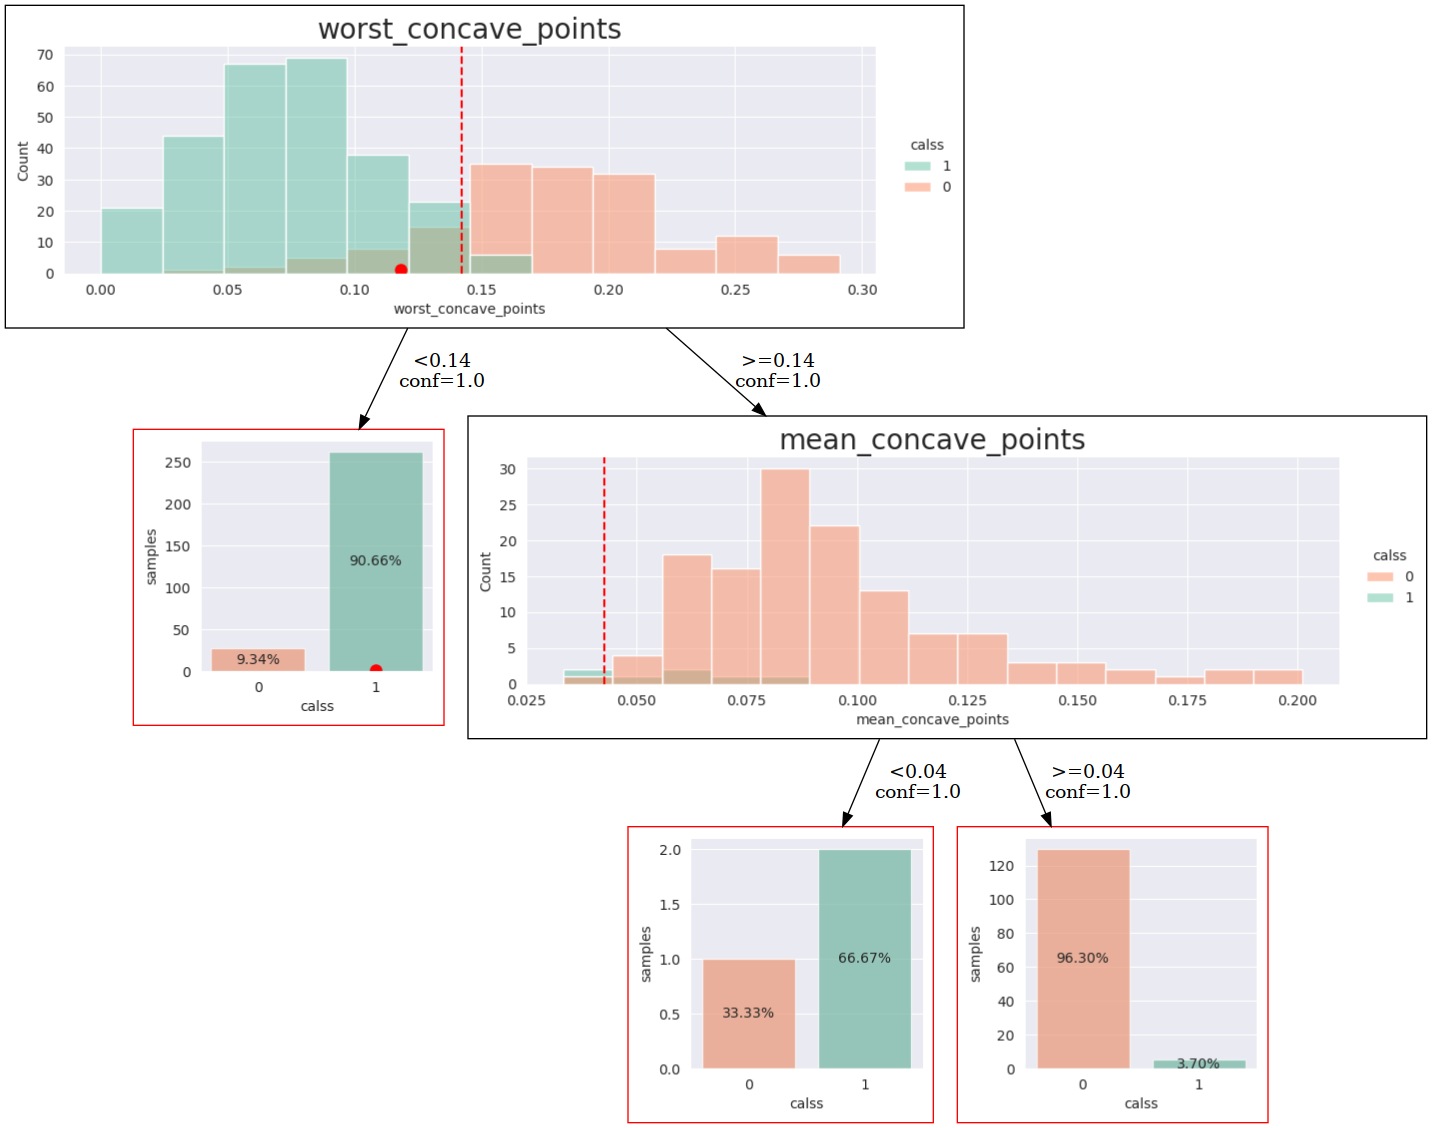

In [75]:
import graphviz
from graphviz import Source
from IPython.display import SVG, Image
i2edf = pd.DataFrame(i2e, columns=features)
i2edf[target] =clf.predict(i2edf.values.reshape(1,-1))[0]
lux.uid3.tree.save_dot('tree-breast-shap.dot',fmt='.2f',visual=True, background_data=train,  instance2explain=i2edf)
gvz=graphviz.Source.from_file('tree-breast-shap.dot')
!dot -Tpng tree-breast-shap.dot > tree-breast-shap.png
Image('tree-breast-shap.png')

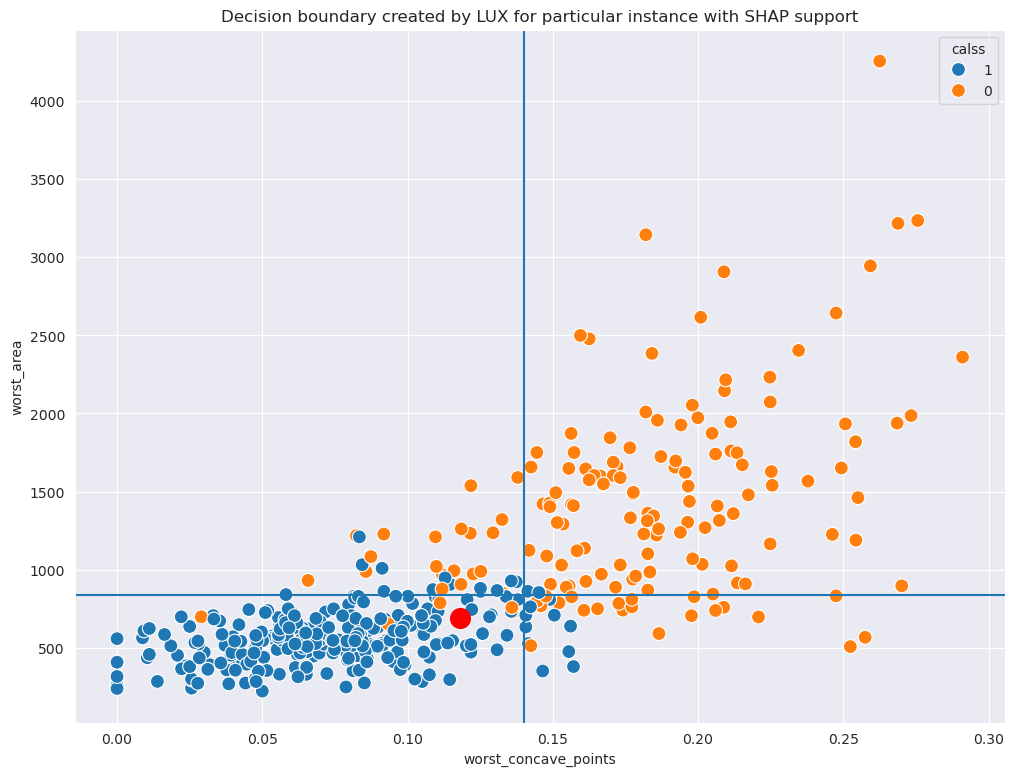

In [76]:
plt.figure(figsize=(12,9))
graph=sns.scatterplot(x='worst_concave_points',y='worst_area', data=train[['worst_concave_points','worst_area',target]],hue=target,s=100)
graph.axvline(0.14)
graph.axhline(839.7)
plt.scatter(data=pd.DataFrame(i2e,columns=features),x='worst_concave_points',y='worst_area', marker='o',color='r', s=200)
plt.title('Decision boundary created by LUX for particular instance with SHAP support')
plt.show()